# Introduction
In this project I will be using 3 Machine Learning models: LSTM, XGBoost and Random Forest to predict the stock price market, and analyze the effectiveness of these models

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import keras
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor

# Collecting data

In [9]:
startDate = '2019-01-01'
endDate = '2023-11-7'
KO_data = yf.download('KO', startDate, endDate)

[*********************100%%**********************]  1 of 1 completed


Dataset of Coca-Cola company

In [10]:
KO_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,46.939999,47.220001,46.560001,46.930000,40.147369,11603700
2019-01-03,46.820000,47.369999,46.529999,46.639999,39.899277,14714400
2019-01-04,46.750000,47.570000,46.639999,47.570000,40.694874,13013700
2019-01-07,47.570000,47.750000,46.900002,46.950001,40.164471,13135500
2019-01-08,47.250000,47.570000,47.040001,47.480000,40.617886,15420700
...,...,...,...,...,...,...
2023-10-31,56.570000,56.720001,56.150002,56.490002,56.043747,16639400
2023-11-01,56.799999,56.880001,56.259998,56.439999,55.994141,14110800
2023-11-02,56.500000,57.150002,56.360001,57.090000,56.639008,13087200


Dataset for Walmart company

The statistics of the two companies

In [11]:
KO_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1.221000e+03
mean,55.196593,55.601630,54.755487,55.177011,51.094011,1.511371e+07
std,5.748011,5.744080,5.763482,5.770666,7.128827,6.847259e+06
min,38.759998,38.889999,36.270000,37.560001,33.440441,3.265500e+06
25%,50.619999,51.139999,50.189999,50.689999,45.318920,1.093620e+07
50%,54.750000,55.090000,54.369999,54.730000,50.501583,1.368670e+07
75%,60.279999,60.720001,59.869999,60.330002,58.064529,1.724670e+07
max,67.000000,67.199997,65.720001,66.209999,62.817841,6.784570e+07


## Visualization
The plot for close prices

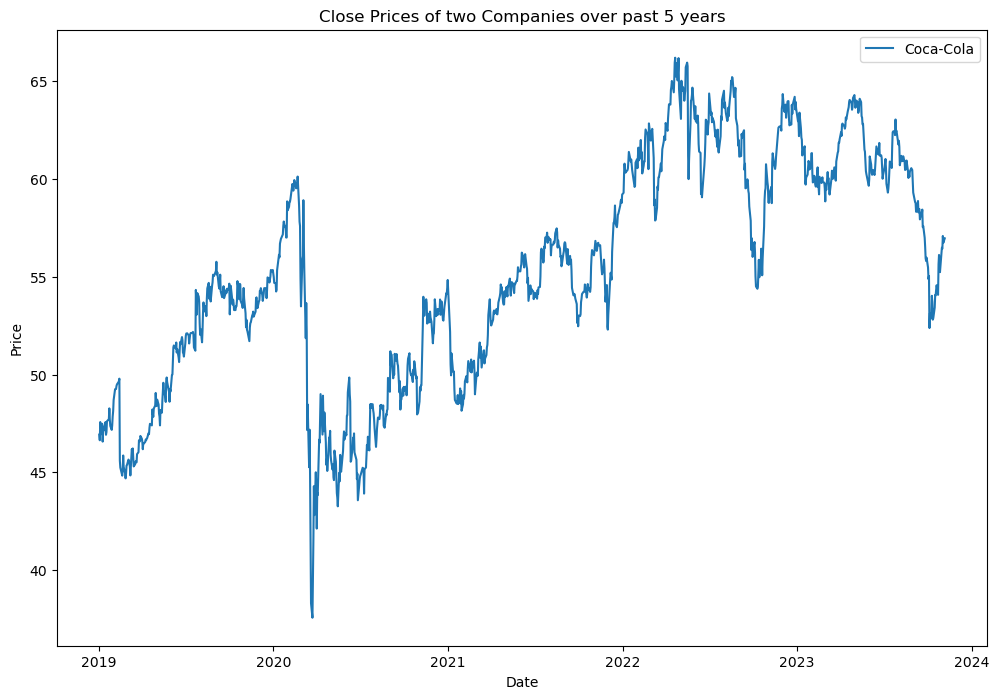

Date
2019-01-02    46.930000
2019-01-03    46.639999
2019-01-04    47.570000
2019-01-07    46.950001
2019-01-08    47.480000
                ...    
2023-10-31    56.490002
2023-11-01    56.439999
2023-11-02    57.090000
2023-11-03    56.740002
2023-11-06    56.970001
Name: Close, Length: 1221, dtype: float64


In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(KO_data['Close'], label='Coca-Cola',linewidth=1.5)
ax.set_title('Close Prices of two Companies over past 5 years')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
plt.show()
print(KO_data['Close'])

The plot for changes of close prices

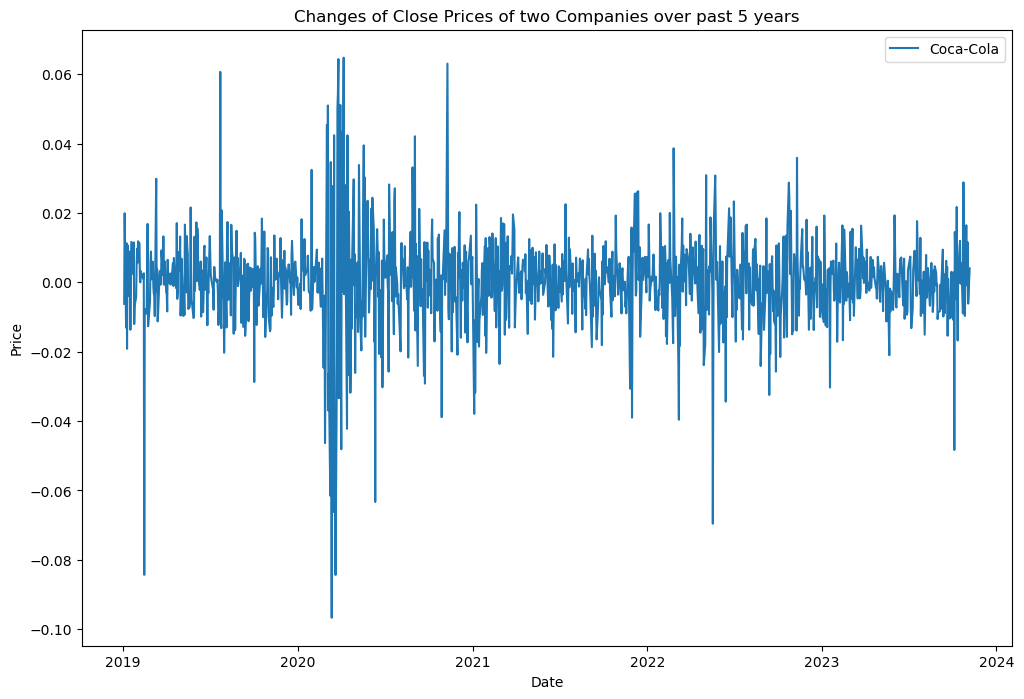

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(KO_data['Close'].pct_change(), label='Coca-Cola',linewidth=1.5)
ax.set_title('Changes of Close Prices of two Companies over past 5 years')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
plt.show()

Using SMA over 15 years to smooth the curves

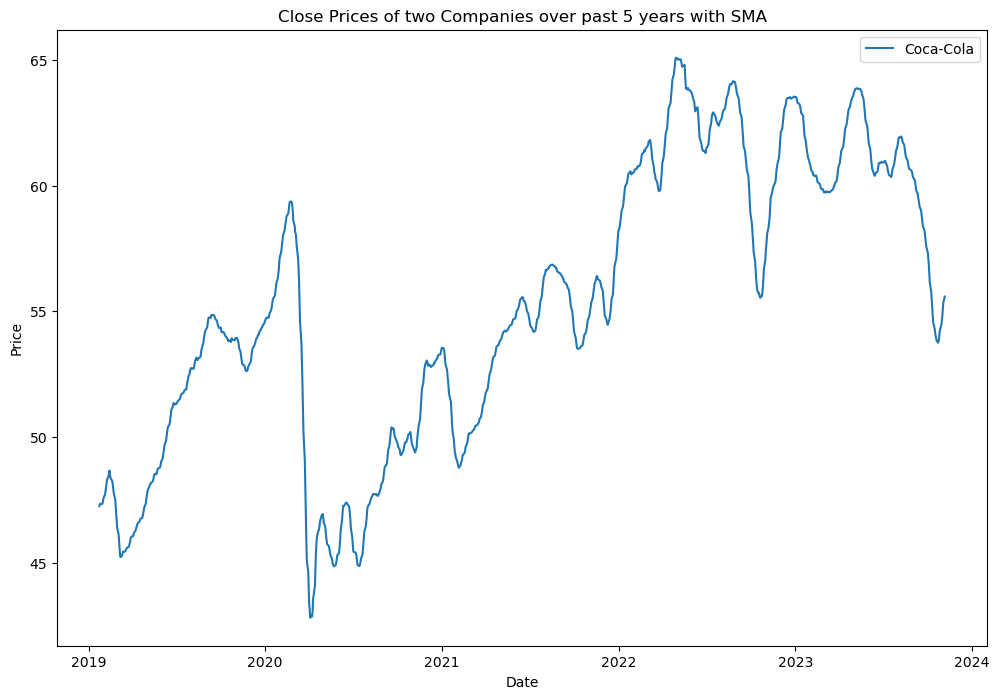

In [14]:

KO_data["SMA"] = KO_data["Close"].rolling(15).mean()
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(KO_data["SMA"],label = 'Coca-Cola',linewidth = 1.5)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title("Close Prices of two Companies over past 5 years with SMA")
ax.legend()
plt.show()


## Feature Selection

Plot and analyze the correlation between features of Coca-Cola, and print out the correlation between the feature and our target "Close" price. We will choose the features that have high correlation.

Coca-Cola

Open         0.994996
High         0.997319
Low          0.997721
Close        1.000000
Adj Close    0.977613
Volume      -0.177258
SMA          0.965995
Name: Close, dtype: float64


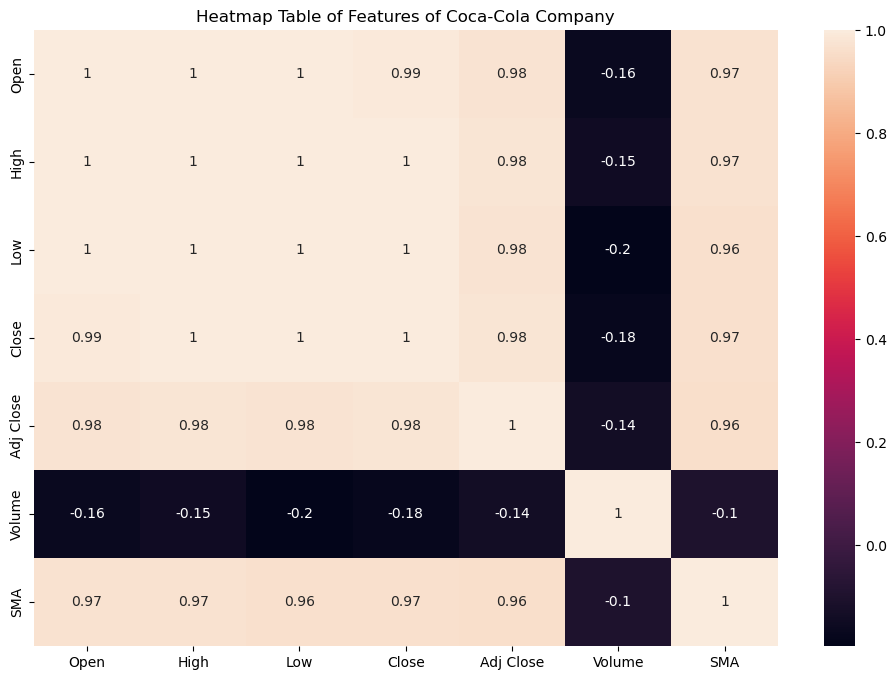

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Heatmap Table of Features of Coca-Cola Company")
sns.heatmap(KO_data.corr(),annot=True)
KO_corr = KO_data.corr()
KO_corr["Close"].sort_values(ascending=True)
print(KO_corr["Close"])

Coca-Cola have high correlation in features Open, High, Low and Adj Close. We will neglect the SMA even though it has high correlation because we calculated SMA from the Close price.

Hence,  Open, High, Low and Adj Close are the 4 features that I will use as input.

# Model Performance

I will measure the economic model using cummulative return on each model averaged over 10 performances.
### Daily Return Formula:

The daily return measures the percentage change in the value of an investment from one day to the next. It is typically calculated using the formula:

Daily Return = (Predicted Closing Price Today - Actual Closing Price Yesterday) / Actual Closing Price Yesterday * 100%

### Cumulative Return Formula:

The cumulative return, also known as the total return, measures the overall percentage change in the value of an investment over a specified period. It is calculated by multiplying together the daily returns over the period of interest and subtracting 1:

Cumulative Return = (Product of (1 + Daily Return_i) for i in 1 to n) - 1

This represents how much money earned when we use our model to predict the stock market


## LSTM

LSTM model for Coca-Cola, using the last 60 days to predict the current day

In [16]:
KO_data_lstm = KO_data.copy()
KO_data_lstm_X = KO_data_lstm.filter(["Close","Open","High","Low"])
KO_lstm_scaler = MinMaxScaler(feature_range=(0,1))
KO_data_lstm_X["Close"] = KO_lstm_scaler.fit_transform(KO_data_lstm_X["Close"].values.reshape(-1,1))
KO_data_lstm_X["Open"] = KO_lstm_scaler.fit_transform(KO_data_lstm_X["Open"].values.reshape(-1,1))
KO_data_lstm_X["High"] = KO_lstm_scaler.fit_transform(KO_data_lstm_X["High"].values.reshape(-1,1))
KO_data_lstm_X["Low"] = KO_lstm_scaler.fit_transform(KO_data_lstm_X["Low"].values.reshape(-1,1))
KO_lstm_scaled_data = KO_data_lstm_X.values
# print(KO_lstm_scaled_data.shape) # = (1221,4)

#create sequence to feed in LSTM
#X shape = (1661,60,4), y shape = (1661,4)
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps,len(data)):
        X.append(data[(i - n_steps):i])
        y.append(data[i])
    return np.array(X), np.array(y)
# print(X.shape)
# print(y.shape)
KO_lstm_train_len = int(np.floor(len(KO_lstm_scaled_data)*0.8))
KO_lstm_train_X = KO_lstm_scaled_data[:KO_lstm_train_len]
KO_lstm_test_X = KO_lstm_scaled_data[KO_lstm_train_len-60:]
X_train,y_train = create_sequences(KO_lstm_train_X,60)
X_test, y_test = create_sequences(KO_lstm_test_X,60)
print(X_train.shape)
print(X_test.shape)
# print(X_test)

def build_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer=keras.optimizers.Adam(0.005), loss='mean_squared_error')
    return model

KO_cr = np.zeros(len(y_test))
KO_pr = np.zeros(len(y_test))
dates = []
KO_LSTM_MSE = 0
for _ in range(10):
    KO_lstm = build_LSTM()
    KO_lstm.fit(X_train,y_train,epochs= 10, batch_size= 32, verbose=0)
    y_pred = KO_lstm.predict(X_test)
    # Inverse transform the predictions and actual values to get them in the original scale
    y_pred = KO_lstm_scaler.inverse_transform(y_pred)
    y_test_orig = KO_lstm_scaler.inverse_transform(y_test)[:,1]
    y_test_orig = y_test_orig.reshape(-1,1)
    KO_LSTM_MSE += mean_squared_error(y_test_orig, y_pred)
    # print(y_pred.shape) = (233,1)
    # print(y_test_orig)
    # print(len(X_train))
    for i in range(len(y_pred)):
        dates.append(KO_data_lstm_X['Close'].axes[0][len(X_train)+i+60])

    # print(np.array(dates).shape) = (233,)
    # Create the results DataFrame
    results = pd.DataFrame({
        'Date': np.array(dates),
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred.flatten()
    })
    dates = []
    results['Signal'] = 0
    results['Baseline Signal'] = 0
    results.loc[results['Predicted'].shift(1) > results['Actual'], 'Signal'] = 1  
    results.loc[results['Predicted'].shift(1) < results['Actual'], 'Signal'] = -1

    results['Daily_Return'] = results['Actual'].pct_change() * results['Signal'].shift(1)
    results['Cumulative_Return'] = (1 + results['Daily_Return']).cumprod()-1

    # print(results['Cumulative_Return'].values.shape)
    KO_cr += results['Cumulative_Return'].values
    KO_pr += results['Predicted'].values
    # print(results)
KO_cr/=10
KO_pr/=10
KO_LSTM_MSE /= 10
results['Cumulative_Return'] = KO_cr
results['Predicted'] = KO_pr
# print(results)
print(f'The averaged MSE loss for the LSTM model is: {KO_LSTM_MSE}')


(916, 60, 4)
(245, 60, 4)


2023-12-31 04:12:24.071282: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 0s 2ms/step
The averaged MSE loss for the LSTM model is: 0.6979188698859444


## Visualizing for LSTM
Visualize:
1. The actual and predicted price
2. The actual and predicted percentage of change
3. The cumulative return that we get if we follow the actual stock market and our model. The baseline will be the actual cumulative return

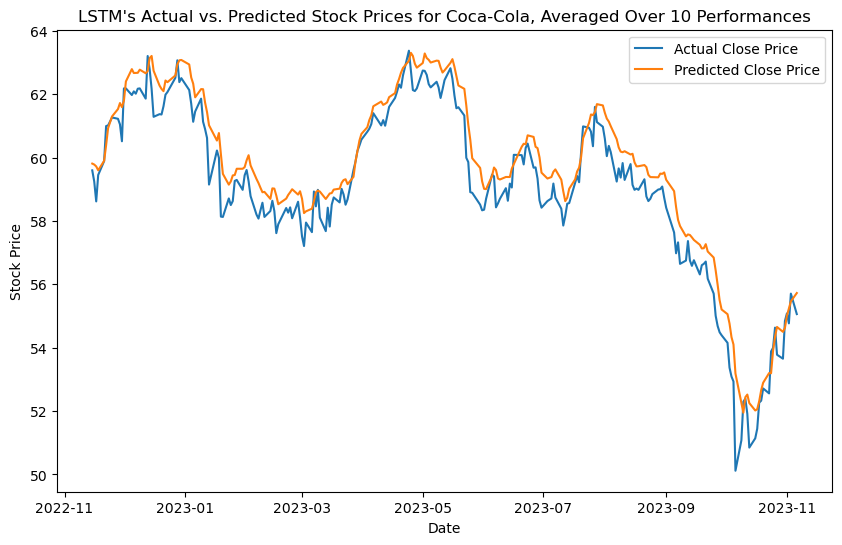

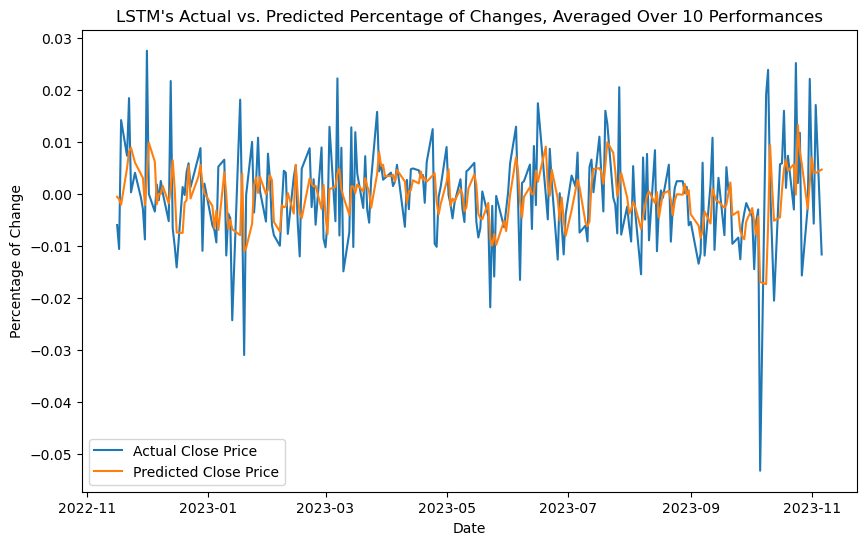

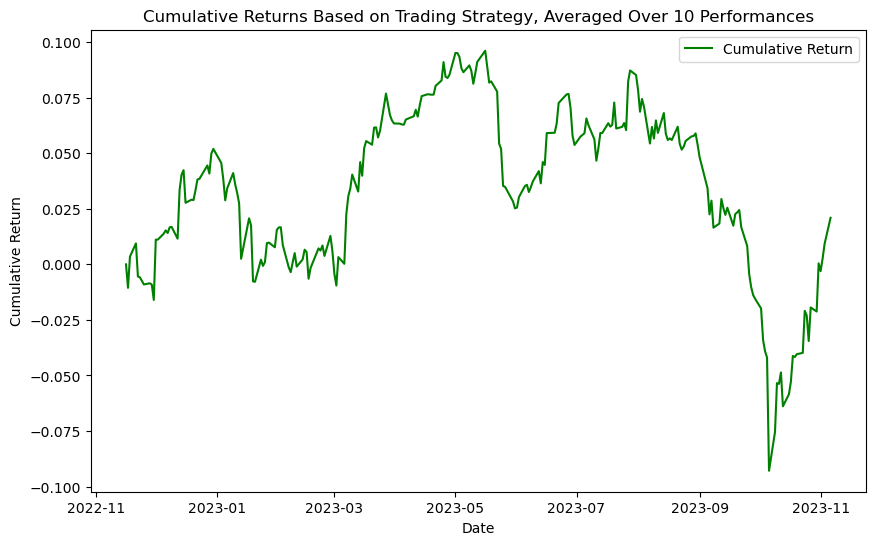

The cumulative return for Coca-Cola company is: 0.020965593160660267


In [17]:
plt.figure(figsize=(10, 6))
plt.plot(results['Date'], results['Actual'], label='Actual Close Price')
plt.plot(results['Date'], KO_pr, label='Predicted Close Price')
plt.legend()
plt.title("LSTM's Actual vs. Predicted Stock Prices for Coca-Cola, Averaged Over 10 Performances")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results['Date'], results['Actual'].pct_change(), label='Actual Close Price')
plt.plot(results['Date'], results['Predicted'].pct_change(), label='Predicted Close Price')
plt.legend()
plt.title("LSTM's Actual vs. Predicted Percentage of Changes, Averaged Over 10 Performances")
plt.xlabel("Date")
plt.ylabel("Percentage of Change")
plt.show()
# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(results['Date'], KO_cr, label='Cumulative Return', color='green')
plt.legend()
plt.title('Cumulative Returns Based on Trading Strategy, Averaged Over 10 Performances')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()
KO_lr = KO_cr[-1]
print(f'The cumulative return for Coca-Cola company is: {KO_lr}')

## GRU

The Gated Recurrent Unit is a simplified model of the LSTM.
The GRU model for predicting Coca Cola stock price, which is almost identical to LSTM

In [18]:
# Copy the data and select relevant columns
KO_data_gru = KO_data.copy()
KO_data_gru_X = KO_data_gru.filter(["Close", "Open", "High", "Low"])

# Scale the data
KO_gru_scaler = MinMaxScaler(feature_range=(0, 1))
for column in KO_data_gru_X.columns:
    KO_data_gru_X[column] = KO_gru_scaler.fit_transform(KO_data_gru_X[column].values.reshape(-1, 1))

KO_gru_scaled_data = KO_data_gru_X.values

def create_sequences_gru(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[(i - n_steps):i])
        y.append(data[i])
    return np.array(X), np.array(y)

KO_gru_train_len = int(np.floor(len(KO_gru_scaled_data) * 0.8))
KO_gru_train_X = KO_gru_scaled_data[:KO_gru_train_len]
KO_gru_test_X = KO_gru_scaled_data[KO_gru_train_len - 60:]
X_train_gru, y_train_gru = create_sequences_gru(KO_gru_train_X, 60)
X_test_gru, y_test_gru = create_sequences_gru(KO_gru_test_X, 60)


def build_GRU():
    model = Sequential()
    model.add(GRU(units=50, activation='relu', input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer=keras.optimizers.Adam(0.005), loss='mean_squared_error')
    return model


KO_cr_gru = np.zeros(len(y_test_gru))
KO_pr_gru = np.zeros(len(y_test_gru))
dates_gru = []
KO_GRU_MSE = 0

for _ in range(10):
    KO_gru = build_GRU()
    KO_gru.fit(X_train_gru, y_train_gru, epochs=10, batch_size=32, verbose=0)
    y_pred_gru = KO_gru.predict(X_test_gru)
    y_pred_gru = KO_gru_scaler.inverse_transform(y_pred_gru)
    y_test_orig_gru = KO_gru_scaler.inverse_transform(y_test_gru[:,1].reshape(-1,1))
    KO_GRU_MSE += mean_squared_error(y_test_orig_gru, y_pred_gru)

    for i in range(len(y_pred_gru)):
        dates_gru.append(KO_data_gru_X['Close'].axes[0][len(X_train_gru) + i + 60])

    results_gru = pd.DataFrame({
        'Date': np.array(dates_gru),
        'Actual': y_test_orig_gru.flatten(),
        'Predicted': y_pred_gru.flatten()
    })

    dates_gru = []
    results_gru['Signal'] = 0
    results_gru.loc[results_gru['Predicted'].shift(1) > results_gru['Actual'], 'Signal'] = 1
    results_gru.loc[results_gru['Predicted'].shift(1) < results_gru['Actual'], 'Signal'] = -1

    results_gru['Daily_Return'] = results_gru['Actual'].pct_change() * results_gru['Signal'].shift(1)
    results_gru['Cumulative_Return'] = (1 + results_gru['Daily_Return']).cumprod() - 1

    KO_cr_gru += results_gru['Cumulative_Return'].values
    KO_pr_gru += results_gru['Predicted'].values

KO_cr_gru /= 10
KO_pr_gru /= 10
KO_GRU_MSE /= 10

results_gru['Cumulative_Return'] = KO_cr_gru
results_gru['Predicted'] = KO_pr_gru
print(results_gru)
print(f'The averaged MSE loss for the GRU model is: {KO_GRU_MSE}')

8/8 [==============================] - 0s 2ms/step
          Date     Actual  Predicted  Signal  Daily_Return  Cumulative_Return
0   2022-11-15  59.598491  60.077896       0           NaN                NaN
1   2022-11-16  59.243922  59.784606       1     -0.000000           0.000000
2   2022-11-17  58.618212  59.616354       1     -0.010562          -0.010562
3   2022-11-18  59.452493  59.412194       1      0.014232           0.003521
4   2022-11-21  59.890486  59.962209      -1      0.007367           0.009435
..         ...        ...        ...     ...           ...                ...
240 2023-10-31  54.843107  54.646411      -1      0.022158           0.041597
241 2023-11-01  55.082961  55.242719      -1     -0.004373           0.037041
242 2023-11-02  54.770108  55.419377       1      0.005680           0.042931
243 2023-11-03  55.708672  55.634203      -1      0.017136           0.057270
244 2023-11-06  55.062104  55.913792       1      0.011606           0.069541

[245 rows x 

## Visualization for GRU

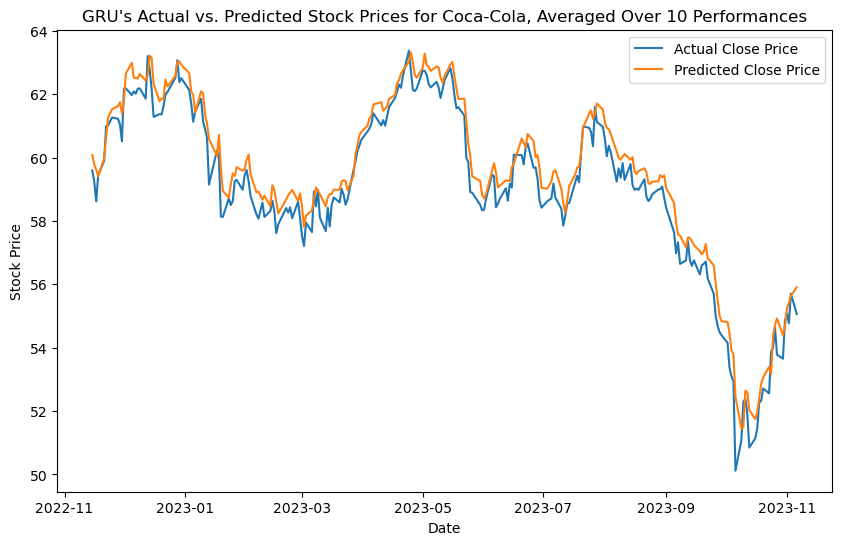

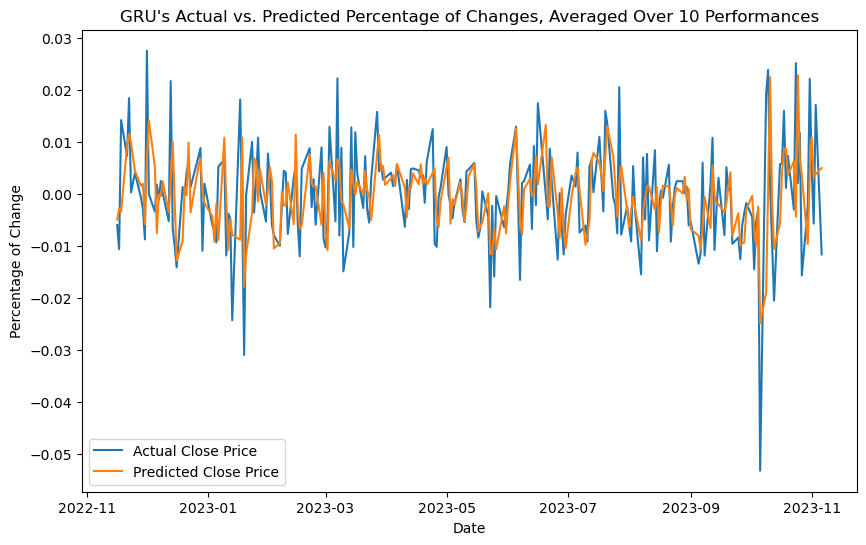

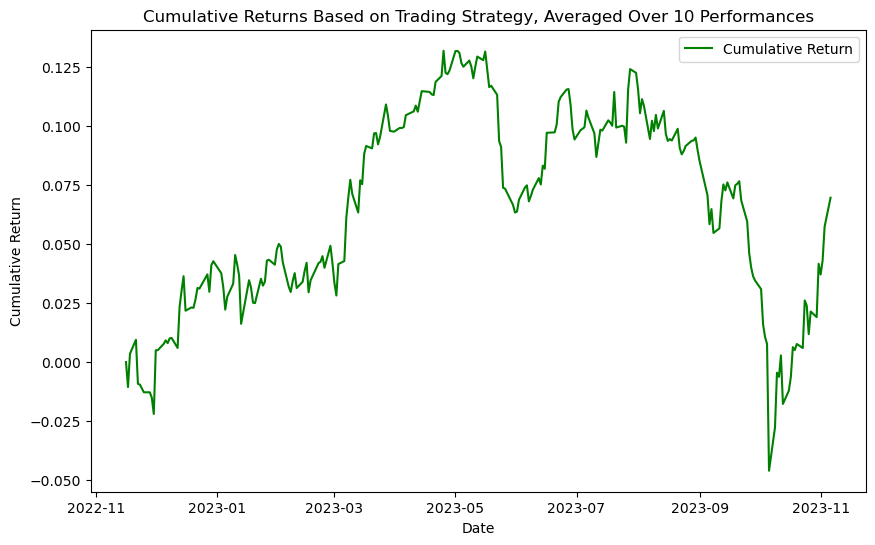

The cumulative return for Coca-Cola company is: 0.06954112255908837


In [19]:
plt.figure(figsize=(10, 6))
plt.plot(results_gru['Date'], results_gru['Actual'], label='Actual Close Price')
plt.plot(results_gru['Date'], KO_pr_gru, label='Predicted Close Price')
plt.legend()
plt.title("GRU's Actual vs. Predicted Stock Prices for Coca-Cola, Averaged Over 10 Performances")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_gru['Date'], results_gru['Actual'].pct_change(), label='Actual Close Price')
plt.plot(results_gru['Date'], results_gru['Predicted'].pct_change(), label='Predicted Close Price')
plt.legend()
plt.title("GRU's Actual vs. Predicted Percentage of Changes, Averaged Over 10 Performances")
plt.xlabel("Date")
plt.ylabel("Percentage of Change")
plt.show()
# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(results_gru['Date'], KO_cr_gru, label='Cumulative Return', color='green')
plt.legend()
plt.title('Cumulative Returns Based on Trading Strategy, Averaged Over 10 Performances')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()
KO_lr_gru = KO_cr_gru[-1]
print(f'The cumulative return for Coca-Cola company is: {KO_lr_gru}')

## XGBoost

In [20]:
selected_features = ["Close", "Open", "High", "Low"]
KO_data_xgb = KO_data.copy()
KO_data_xgb_X = KO_data_xgb.filter(["Close", "Open", "High", "Low"])

# Scale the data
xgb_scaler = MinMaxScaler(feature_range=(0, 1))
for column in KO_data_xgb_X.columns:
    KO_data_xgb_X[column] = xgb_scaler.fit_transform(KO_data_xgb_X[column].values.reshape(-1, 1))

KO_data_xgb_scaled = KO_data_xgb_X.values

# Create lag features for time series data
lagged_data = pd.DataFrame(KO_data_xgb_scaled, columns=selected_features)
for feature in selected_features:
    for i in range(1, 6):  # Create lag features for the past 5 days
        lagged_data[f"{feature}_lag_{i}"] = lagged_data[feature].shift(i)

# Drop rows with NaN values due to lag
lagged_data = lagged_data.dropna()

# Split the data into training and testing sets
train_len = int(len(lagged_data) * 0.8)
train_data = lagged_data[:train_len]
test_data = lagged_data[train_len:]

# Separate features and target variable
X_train = train_data.drop("Close", axis=1)
y_train = train_data["Close"]
X_test = test_data.drop("Close", axis=1)
y_test = test_data["Close"]


KO_cr_xgb = np.zeros(len(y_test))
KO_pr_xgb = np.zeros(len(y_test))
dates_xgb = []
KO_XGB_MSE = 0

for _ in range(10):
    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = np.array(xgb_model.predict(X_test))
    y_pred_xgb = xgb_scaler.inverse_transform(y_pred_xgb.reshape(-1,1))
    y_test_val = y_test.values
    y_test_orig_xgb = xgb_scaler.inverse_transform(y_test_val.reshape(-1,1))
    KO_XGB_MSE += mean_squared_error(y_test_orig_xgb, y_pred_xgb)
    # print(KO_data_xgb['Close'])
    # print(len(X_train))
    for i in range(len(y_pred_xgb)):
        dates_xgb.append(KO_data_xgb['Close'].axes[0][len(X_train) + i])

    results_xgb = pd.DataFrame({
        'Date': np.array(dates_xgb),
        'Actual': y_test_orig_xgb.flatten(),
        'Predicted': y_pred_xgb.flatten()
    })

    dates_xgb = []
    results_xgb['Signal'] = 0
    results_xgb['Baseline Signal'] = 0
    results_xgb.loc[results_xgb['Predicted'].shift(1) > results_xgb['Actual'], 'Signal'] = 1
    results_xgb.loc[results_xgb['Predicted'].shift(1) < results_xgb['Actual'], 'Signal'] = -1

    results_xgb['Daily_Return'] = results_xgb['Actual'].pct_change() * results_xgb['Signal'].shift(1)
    results_xgb['Cumulative_Return'] = (1 + results_xgb['Daily_Return']).cumprod() - 1

    KO_cr_xgb += results_xgb['Cumulative_Return'].values
    KO_pr_xgb += results_xgb['Predicted'].values

KO_cr_xgb /= 10
KO_pr_xgb /= 10
KO_XGB_MSE /= 10

results_xgb['Cumulative_Return'] = KO_cr_xgb
results_xgb['Predicted'] = KO_pr_xgb
print(results_xgb)
print(f'The averaged MSE loss for the XGBoost model is: {KO_XGB_MSE}')

          Date     Actual  Predicted  Signal  Baseline Signal  Daily_Return  \
0   2022-11-09  59.871119  60.122341       0                0           NaN   
1   2022-11-10  60.066423  59.464890       1                0      0.000000   
2   2022-11-11  60.508430  60.264397      -1                0      0.007359   
3   2022-11-14  61.474681  61.392117      -1                0     -0.015969   
4   2022-11-15  61.752217  61.403126      -1                0     -0.004515   
..         ...        ...        ...     ...              ...           ...   
239 2023-10-24  55.728589  55.784023      -1                0     -0.006311   
240 2023-10-25  55.677190  55.686935       1                0      0.000922   
241 2023-10-26  56.345342  55.896671      -1                0      0.012000   
242 2023-10-27  55.985570  56.393345      -1                0      0.006385   
243 2023-10-30  56.221992  56.330536       1                0     -0.004223   

     Cumulative_Return  
0                  NaN  
1

## Visualization XGBoost

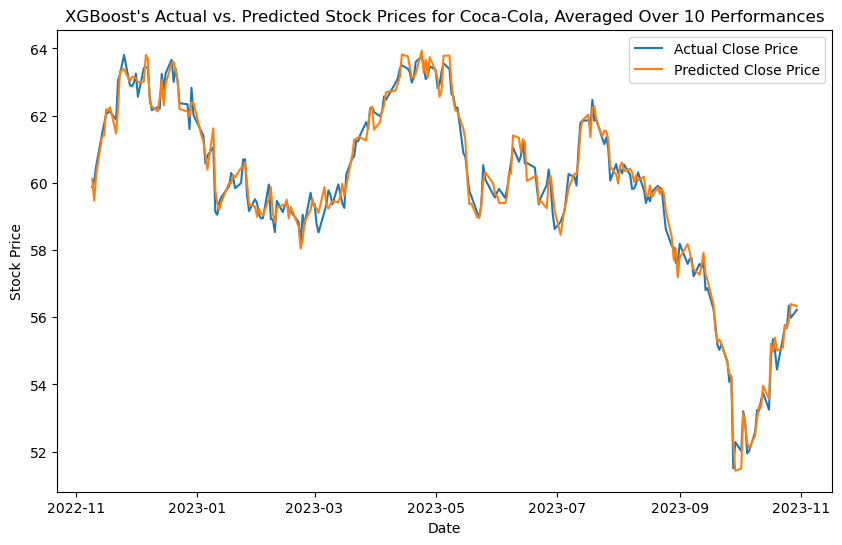

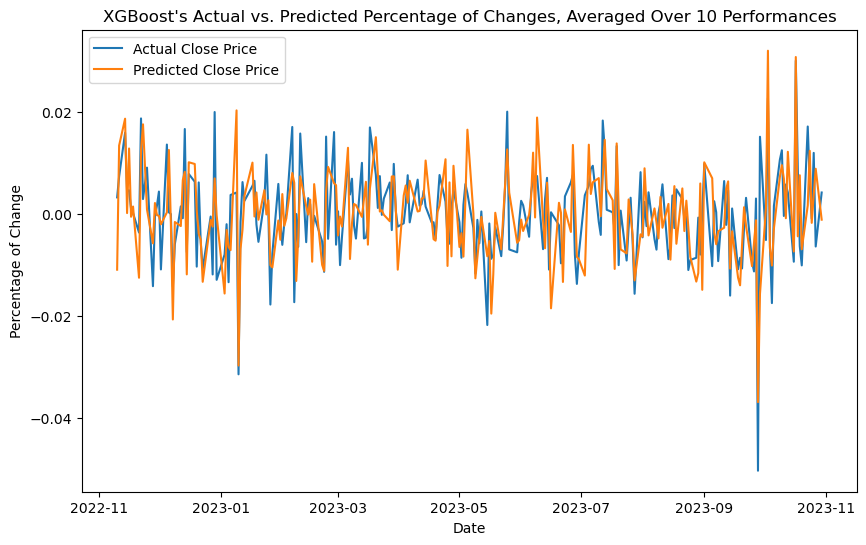

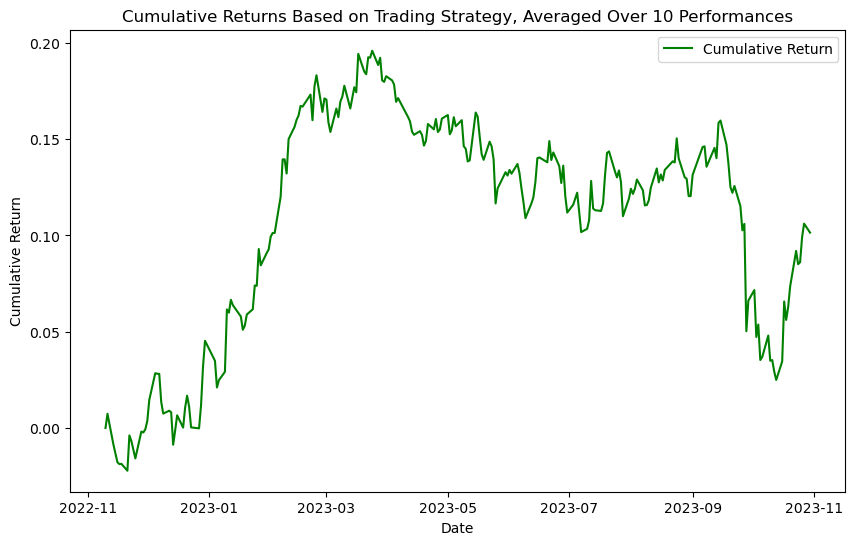

The cumulative return for Coca-Cola company is: 0.1014354521048706


In [21]:
plt.figure(figsize=(10, 6))
plt.plot(results_xgb['Date'], results_xgb['Actual'], label='Actual Close Price')
plt.plot(results_xgb['Date'], KO_pr_xgb, label='Predicted Close Price')
plt.legend()
plt.title("XGBoost's Actual vs. Predicted Stock Prices for Coca-Cola, Averaged Over 10 Performances")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_xgb['Date'], results_xgb['Actual'].pct_change(), label='Actual Close Price')
plt.plot(results_xgb['Date'], results_xgb['Predicted'].pct_change(), label='Predicted Close Price')
plt.legend()
plt.title("XGBoost's Actual vs. Predicted Percentage of Changes, Averaged Over 10 Performances")
plt.xlabel("Date")
plt.ylabel("Percentage of Change")
plt.show()
# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(results_xgb['Date'], KO_cr_xgb, label='Cumulative Return', color='green')
plt.legend()
plt.title('Cumulative Returns Based on Trading Strategy, Averaged Over 10 Performances')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()
KO_lr_xgb = KO_cr_xgb[-1]
print(f'The cumulative return for Coca-Cola company is: {KO_lr_xgb}')

# Conclusion

We should use MSE to evaluate how well our model predicts the future stock price. That is:

XGBoost > GRU > LSTM
in predicting stock price market

GRU is almost identical to LSTM, when running more experiments, GRU might not be always performing better than LSTM.